# Homework 7
## Caleb Maddry

In [19]:
# Importing of packages
import math 
import numpy as np 
import matplotlib.pyplot as plt
import pandoc
import time 

# Subpackages
from numpy.linalg import inv
from numpy.linalg import norm 
from fractions import Fraction

#### Question 1

In [20]:
def create_natural_spline(yint,xint,N):

#    create the right  hand side for the linear system
    b = np.zeros(N+1)
#  vector values
    h = np.zeros(N+1)  
    for i in range(1,N):
       hi = xint[i]-xint[i-1]
       hip = xint[i+1] - xint[i]
       b[i] = (yint[i+1]-yint[i])/hip - (yint[i]-yint[i-1])/hi
       h[i-1] = hi
       h[i] = hip

#  create matrix so you can solve for the M values
# This is made by filling one row at a time 
    A = np.zeros((N+1,N+1))
    A[0][0] = 1.0
    for j in range(1,N):
       A[j][j-1] = h[j-1]/6
       A[j][j] = (h[j]+h[j-1])/3 
       A[j][j+1] = h[j]/6
    A[N][N] = 1

    Ainv = inv(A)
    
    M  = Ainv.dot(b)

#  Create the linear coefficients
    C = np.zeros(N)
    D = np.zeros(N)
    for j in range(N):
       C[j] = yint[j]/h[j]-h[j]*M[j]/6
       D[j] = yint[j+1]/h[j]-h[j]*M[j+1]/6
    return(M,C,D)


def create_clamped_spline(yint,xint, df, N):

#    create the right  hand side for the linear system
    b = np.zeros(N+1)
    b[0] = df[0]

#  vector values
    h = np.zeros(N+1)  
    for i in range(1,N):
       hi = xint[i]-xint[i-1]
       hip = xint[i+1] - xint[i]
       b[i] = (yint[i+1]-yint[i])/hip - (yint[i]-yint[i-1])/hi
       h[i-1] = hi
       h[i] = hip

    b[N] = df[1]

#  create matrix so you can solve for the M values
# This is made by filling one row at a time 
    A = np.zeros((N+1,N+1))
    A[0][0] = 1.0
    A[0][1] = 0
    for j in range(1,N):
       A[j][j-1] = h[j-1]/6
       A[j][j] = (h[j]+h[j-1])/3 
       A[j][j+1] = h[j]/6
    A[N][N-1] = 0
    A[N][N] = 1

    Ainv = inv(A)
    
    M  = Ainv.dot(b)

#  Create the linear coefficients
    C = np.zeros(N)
    D = np.zeros(N)
    for j in range(N):
       C[j] = yint[j]/h[j]-h[j]*M[j]/6
       D[j] = yint[j+1]/h[j]-h[j]*M[j+1]/6
    return(M,C,D)

def create_periodic_spline(yint,xint,N):

#    create the right  hand side for the linear system
    b = np.zeros(N+1)
#  vector values
    h = np.zeros(N+1)  
    for i in range(1,N):
       hi = xint[i]-xint[i-1]
       hip = xint[i+1] - xint[i]
       b[i] = (yint[i+1]-yint[i])/hip - (yint[i]-yint[i-1])/hi
       h[i-1] = hi
       h[i] = hip

#  create matrix so you can solve for the M values
# This is made by filling one row at a time 
    A = np.zeros((N+1,N+1))
    A[0][0] = 1.0
    for j in range(1,N):
       A[j][j-1] = h[j-1]/6
       A[j][j] = (h[j]+h[j-1])/3 
       A[j][j+1] = h[j]/6
    A[N][N] = 1

    # Ensure continuity of the first derivative at the endpoints
    A[N - 1][N - 1] = (h[N - 1] + h[N - 2]) / 3
    A[N - 1][N - 2] = h[N - 2] / 6
    A[N - 1][0] = -h[N - 1] / 6

    Ainv = inv(A)
    
    M  = Ainv.dot(b)

#  Create the linear coefficients
    C = np.zeros(N)
    D = np.zeros(N)
    for j in range(N):
       C[j] = yint[j]/h[j]-h[j]*M[j]/6
       D[j] = yint[j+1]/h[j]-h[j]*M[j+1]/6
    return(M,C,D)

def eval_local_spline(xeval,xi,xip,Mi,Mip,C,D):
# Evaluates the local spline as defined in class
# xip = x_{i+1}; xi = x_i
# Mip = M_{i+1}; Mi = M_i

    hi = xip-xi
    yeval = (Mi*(xip-xeval)**3 +(xeval-xi)**3*Mip)/(6*hi) \
            + C*(xip-xeval) + D*(xeval-xi)
    return yeval 
    

def  eval_cubic_spline(xeval,Neval,xint,Nint,M,C,D):
    
    yeval = np.zeros(Neval+1)
    
    for j in range(Nint):
        '''find indices of xeval in interval (xint(jint),xint(jint+1))'''
        '''let ind denote the indices in the intervals'''
        atmp = xint[j]
        btmp= xint[j+1]
        
#   find indices of values of xeval in the interval
        ind= np.where((xeval >= atmp) & (xeval <= btmp))
        xloc = xeval[ind]

# evaluate the spline
        yloc = eval_local_spline(xloc,atmp,btmp,M[j],M[j+1],C[j],D[j])
#        print('yloc = ', yloc)
#   copy into yeval
        yeval[ind] = yloc

    return(yeval)


def eval_hermite(xeval,xint,yint,ypint,N):

    ''' Evaluate all Lagrange polynomials'''

    lj = np.ones(N+1)
    for count in range(N+1):
       for jj in range(N+1):
           if (jj != count):
              lj[count] = lj[count]*(xeval - xint[jj])/(xint[count]-xint[jj])

    ''' Construct the l_j'(x_j)'''
    lpj = np.zeros(N+1)
#    lpj2 = np.ones(N+1)
    for count in range(N+1):
       for jj in range(N+1):
           if (jj != count):
#              lpj2[count] = lpj2[count]*(xint[count] - xint[jj])
              lpj[count] = lpj[count]+ 1./(xint[count] - xint[jj])
              

    yeval = 0.
    
    for jj in range(N+1):
       Qj = (1.-2.*(xeval-xint[jj])*lpj[jj])*lj[jj]**2
       Rj = (xeval-xint[jj])*lj[jj]**2
#       if (jj == 0):
#         print(Qj)
         
#         print(Rj)
#         print(Qj)
#         print(xeval)
 #        return
       yeval = yeval + yint[jj]*Qj+ypint[jj]*Rj
       
    return(yeval)
       

def eval_lagrange(xeval,xint,yint,N):

    lj = np.ones(N+1)
    
    for count in range(N+1):
       for jj in range(N+1):
           if (jj != count):
              lj[count] = lj[count]*(xeval - xint[jj])/(xint[count]-xint[jj])

    yeval = 0.
    
    for jj in range(N+1):
       yeval = yeval + yint[jj]*lj[jj]
  
    return(yeval)



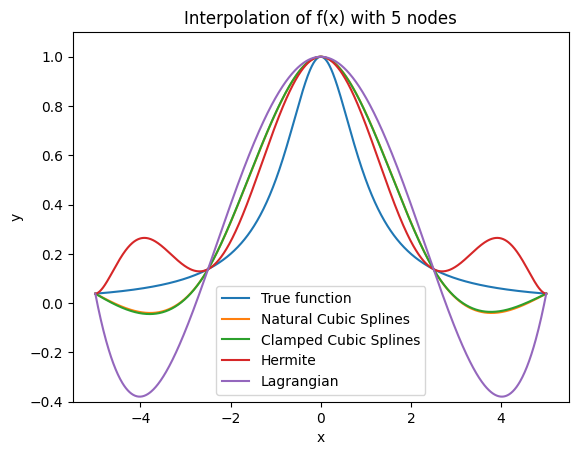

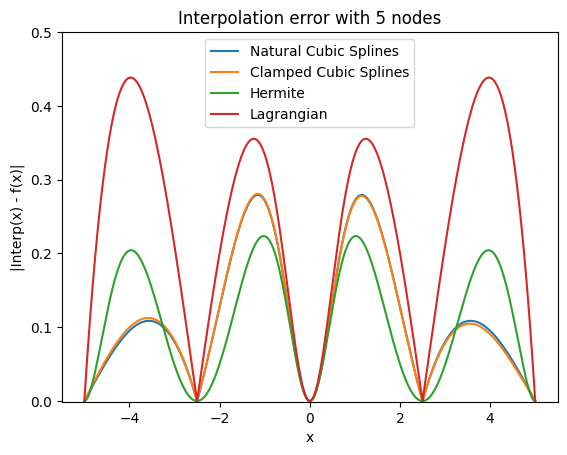

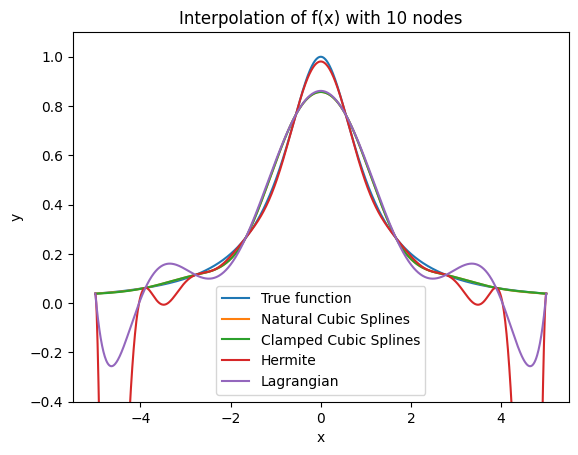

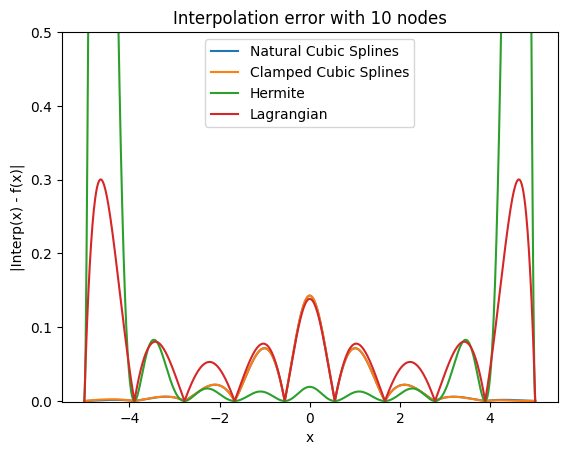

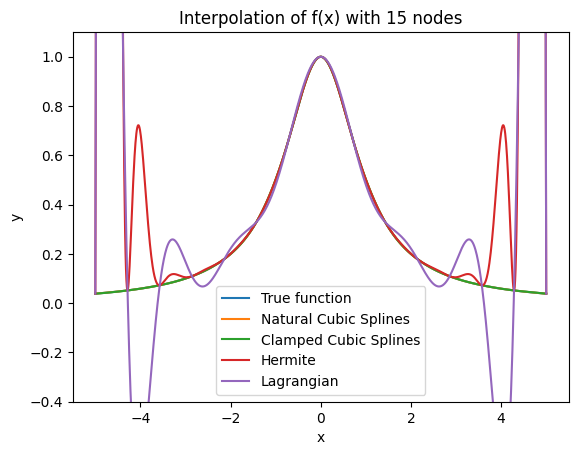

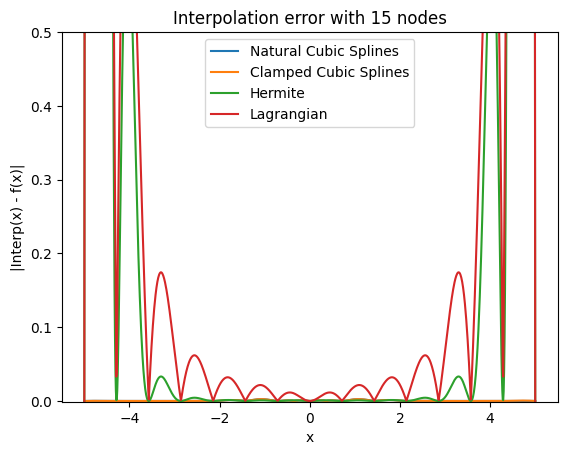

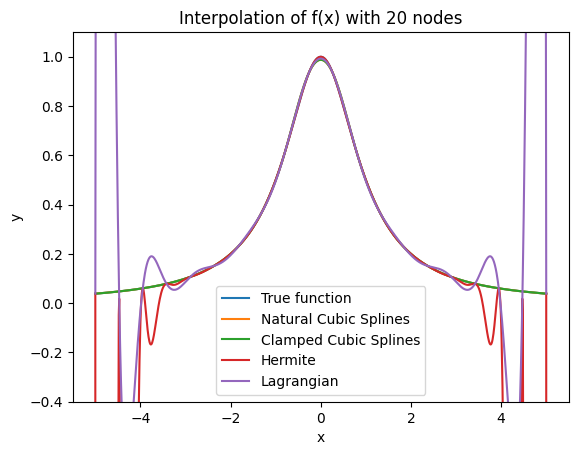

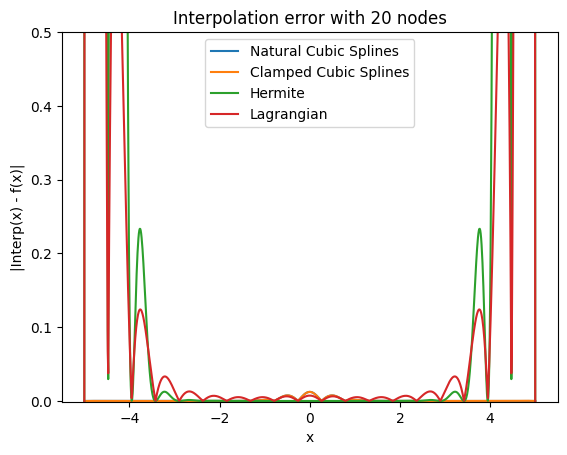

In [21]:
def f(x): return 1/(1+x**2)
def fp(x): return -2*x/(1.+x**2)**2

# Interval 
a = -5
b = 5

for i in [5, 10, 15, 20]:
    # Number of interpolation points
    n = i

    # create equispaced interpolation nodes
    Nint = n - 1
    xint = np.linspace(a, b, Nint + 1)
    yint = f(xint)
    ypint = fp(xint)

    # create points you want to evaluate at
    Neval = 1000
    xeval = np.linspace(a, b, Neval + 1)

    # Cubic splines
    (M,C,D) = create_natural_spline(yint, xint, Nint)
    yeval_natural_cubic_spline = eval_cubic_spline(xeval, Neval, xint, Nint, M, C, D)

    df = [ypint[0], ypint[Nint]]
    (M,C,D) = create_clamped_spline(yint, xint, df, Nint)
    yeval_clamped_cubic_spline = eval_cubic_spline(xeval, Neval, xint, Nint, M, C, D)

    # create points for evaluating the Lagrange interpolating polynomial
    yeval_Lagrangian = np.zeros(Neval + 1)
    yeval_Hermite = np.zeros(Neval + 1)
    for idx in range(Neval + 1):
        yeval_Lagrangian[idx] = eval_lagrange(xeval[idx], xint, yint, Nint)
        yeval_Hermite[idx] = eval_hermite(xeval[idx], xint, yint, ypint, Nint)

    # evaluate f at the evaluation points
    fExact = f(xeval)

    # Error calculations
    error_natural_cubic_spline = abs(yeval_natural_cubic_spline - fExact)  
    error_clamped_cubic_spline = abs(yeval_clamped_cubic_spline - fExact)     
    error_Lagrangian = abs(yeval_Lagrangian - fExact)
    error_Hermite = abs(yeval_Hermite - fExact)  

    # Interpolation plots
    plt.plot(xeval, fExact,
            label="True function")
    plt.plot(xeval, yeval_natural_cubic_spline,
            label="Natural Cubic Splines")
    plt.plot(xeval, yeval_clamped_cubic_spline,
            label="Clamped Cubic Splines")
    plt.plot(xeval, yeval_Hermite,
            label="Hermite")
    plt.plot(xeval, yeval_Lagrangian,
            label="Lagrangian")
    plt.ylim([-0.4, 1.1])
    plt.title("Interpolation of f(x) with " + str(n) + " nodes"); plt.xlabel("x"); plt.ylabel("y"); plt.legend(loc='best')
    plt.show()

    # Error plots
    plt.plot(xeval, error_natural_cubic_spline,
            label="Natural Cubic Splines")
    plt.plot(xeval, error_clamped_cubic_spline,
            label="Clamped Cubic Splines")
    plt.plot(xeval, error_Hermite,
            label="Hermite")
    plt.plot(xeval, error_Lagrangian,
            label="Lagrangian")
    plt.ylim([-0.001, 0.5])
    plt.title("Interpolation error with " + str(n) + " nodes"); plt.xlabel("x"); plt.ylabel("|Interp(x) - f(x)|"); plt.legend(loc='best')
    plt.show()



#### Question 2

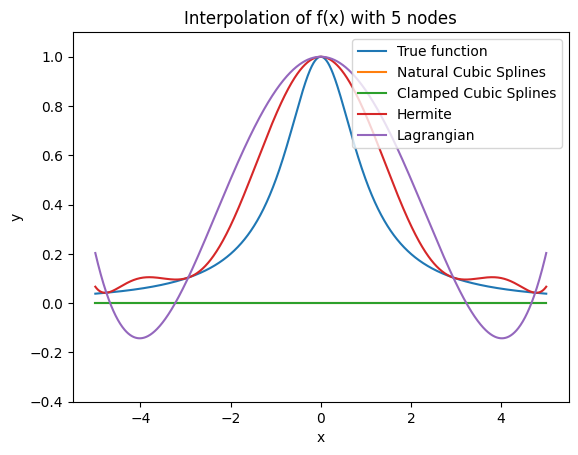

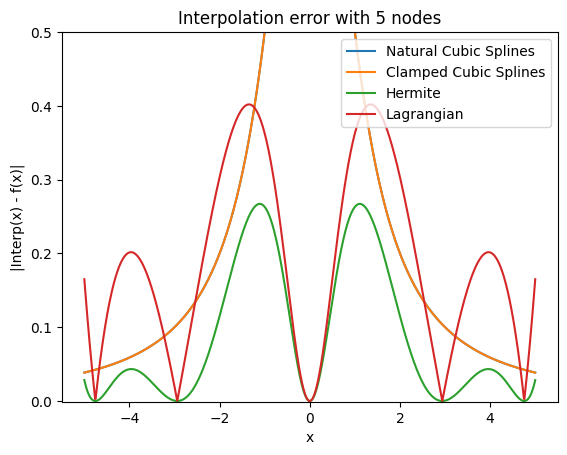

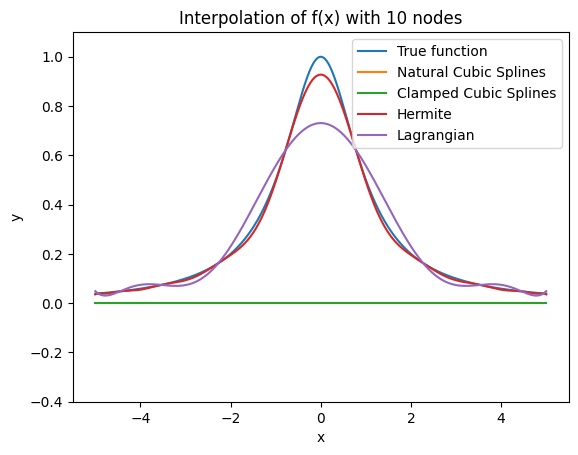

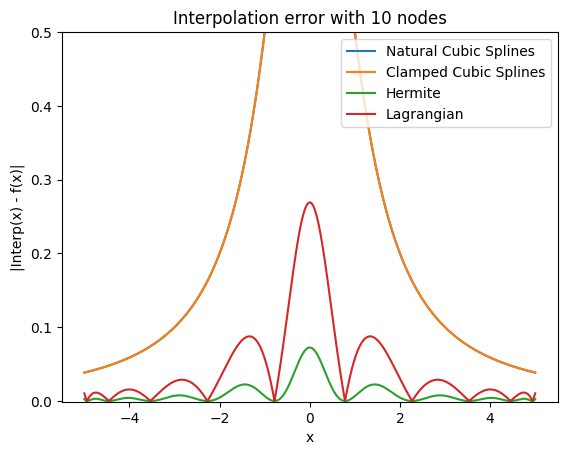

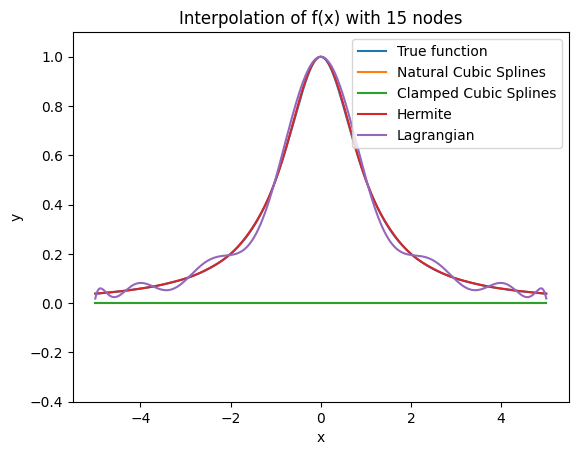

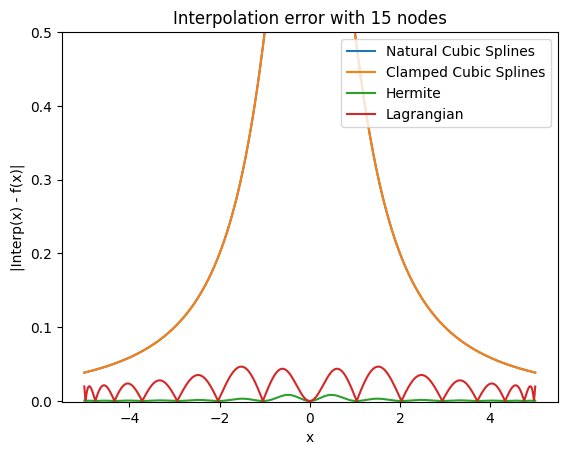

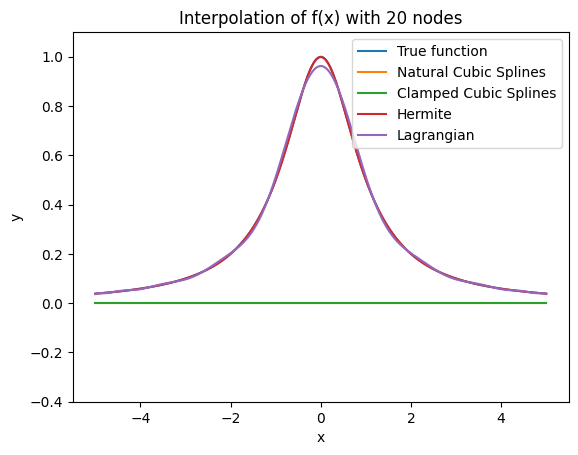

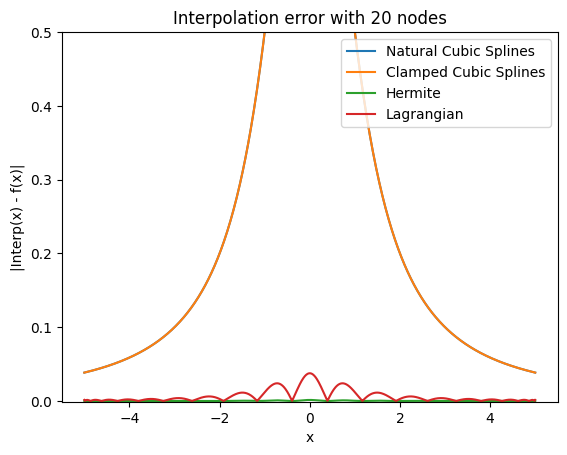

In [22]:

for i in [5,10,15, 20]:
        # Number of interpolation points
        n = i

        # create equispaced interpolation nodes
        Nint = n - 1
        i = np.linspace(1, Nint + 1, Nint + 1)
        xint = (a + b)/2 + ((b - a)/2)*np.cos(((2*i - 1)*np.pi)/(2*(Nint+1)))
        yint = f(xint)
        ypint = fp(xint)

        # create points you want to evaluate at
        Neval = 1000
        xeval = np.linspace(a, b, Neval + 1)


        # Cubic splines
        (M,C,D) = create_natural_spline(yint, xint, Nint)
        yeval_natural_cubic_spline = eval_cubic_spline(xeval, Neval, xint, Nint, M, C, D)

        df = [ypint[0], ypint[Nint]]
        (M,C,D) = create_clamped_spline(yint, xint, df, Nint)
        yeval_clamped_cubic_spline = eval_cubic_spline(xeval, Neval, xint, Nint, M, C, D)

        # create points for evaluating the Lagrange interpolating polynomial
        yeval_Lagrangian = np.zeros(Neval + 1)
        yeval_Hermite = np.zeros(Neval + 1)
        for idx in range(Neval + 1):
                yeval_Lagrangian[idx] = eval_lagrange(xeval[idx], xint, yint, Nint)
                yeval_Hermite[idx] = eval_hermite(xeval[idx], xint, yint, ypint, Nint)

        # evaluate f at the evaluation points
        fExact = f(xeval)

        # Error calculations
        error_natural_cubic_spline = abs(yeval_natural_cubic_spline - fExact)  
        error_clamped_cubic_spline = abs(yeval_clamped_cubic_spline - fExact)     
        error_Lagrangian = abs(yeval_Lagrangian - fExact)
        error_Hermite = abs(yeval_Hermite - fExact)  

        # Interpolation plots
        plt.plot(xeval, fExact,
                label="True function")
        plt.plot(xeval, yeval_natural_cubic_spline,
                label="Natural Cubic Splines")
        plt.plot(xeval, yeval_clamped_cubic_spline,
                label="Clamped Cubic Splines")
        plt.plot(xeval, yeval_Hermite,
                label="Hermite")
        plt.plot(xeval, yeval_Lagrangian,
                label="Lagrangian")
        plt.ylim([-0.4, 1.1])
        plt.title("Interpolation of f(x) with " + str(n) + " nodes"); plt.xlabel("x"); plt.ylabel("y"); plt.legend(loc='best')
        plt.show()

        # Error plots
        plt.plot(xeval, error_natural_cubic_spline,
                label="Natural Cubic Splines")
        plt.plot(xeval, error_clamped_cubic_spline,
                label="Clamped Cubic Splines")
        plt.plot(xeval, error_Hermite,
                label="Hermite")
        plt.plot(xeval, error_Lagrangian,
                label="Lagrangian")
        plt.ylim([-0.001, 0.5])
        plt.title("Interpolation error with " + str(n) + " nodes"); plt.xlabel("x"); plt.ylabel("|Interp(x) - f(x)|"); plt.legend(loc='best')
        plt.show()

#### Question 3

In [31]:
def f(x): return np.sin(10*x)
def fp(x): 10*np.cos(10*x)

a = 0
b = 10*np.pi


# # Number of interpolation points
# n = 10

# # create equispaced interpolation nodes
# Nint = n - 1
# i = np.linspace(1, Nint + 1, Nint + 1)
# xint = np.linspace(a, b, Nint + 1)
# yint = f(xint)
# ypint = fp(xint)

# # create points you want to evaluate at
# Neval = 1000
# xeval = np.linspace(a, b, Neval + 1)


# # Cubic splines
# (M,C,D) = create_periodic_spline(yint, xint, Nint)
# yeval_periodic_cubic_spline = eval_cubic_spline(xeval, Neval, xint, Nint, M, C, D)


# plt.plot(xeval, yeval_periodic_cubic_spline)
# plt.plot(xeval, f(xeval))


